This post provides a short demonstration of how to use the RDKit's feature map implementation to score aligned 3D conformations against each other based on the overlap of their pharmacophoric features.
The idea of the feature map is not a new one and there are numerous publications on the topic. These two come closest to describing the RDKit implementation:

1. Putta, S., Landrum, G. A. & Penzotti, J. E. "Conformation mining: An algorithm for finding biologically relevant conformations." *J. Med. Chem.* **48**, 3313–3318 (2005).
http://pubs.acs.org/doi/abs/10.1021/jm049066l
2. Landrum, G. A., Penzotti, J. E. & Putta, S. "Feature-map vectors: a new class of informative descriptors for computational drug discovery." *J. Comput. Aided. Mol. Des.* **20**, 751–762 (2007).
https://link.springer.com/article/10.1007/s10822-006-9085-8


In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import time
print(time.asctime())
from rdkit import rdBase
print(rdBase.rdkitVersion)

Thu Nov  9 08:17:29 2017
2017.09.1


For this post we'll use a set of three 5HT-3 ligands.

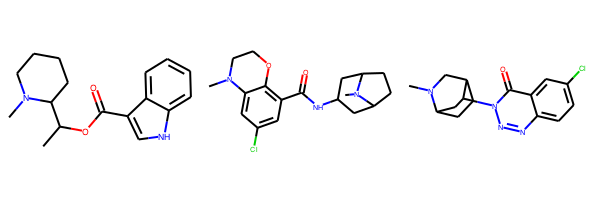

In [2]:
smis = ['CC(OC(=O)c1c[nH]c2ccccc12)C1CCCCN1C',
 'CN1CCOc2c(C(=O)NC3CC4CCC(C3)N4C)cc(Cl)cc21',
 'CN1CC2CCC1CC2n1nnc2ccc(Cl)cc2c1=O']
ms = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(ms)

Start by generating a conformation for each:

In [3]:
ms = [Chem.AddHs(m) for m in ms]
ps = AllChem.ETKDG()
ps.randomSeed = 0xf00d  # we seed the RNG so that this is reproducible
for m in ms:
    AllChem.EmbedMolecule(m,ps)

To get sensible scores for the feature maps, we need to start from aligned structures. For this example we'll just use the RDKit's Open3D Align implementation:

In [4]:
from rdkit.Chem import rdMolAlign
o3d = rdMolAlign.GetO3A(ms[1],ms[0])
o3d.Align()

0.34363011582550307

In [5]:
o3d = rdMolAlign.GetO3A(ms[2],ms[0])
o3d.Align()

0.5938107267982091

Now let's build a feature map.

We need to start by building a `FeatureFactory` object which defines the set of pharmacophore features being used. We'll use this to find features on the molecules.

In [6]:
import os
from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))
print(fdef.GetFeatureFamilies())

('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


We also need the parameters for the points used to make up the feature map.
The feature points are defined by
  - a `FeatProfile` - `Gaussian`, `Triangle`, or `Box`. `Gaussian` is the default.
  - a width - the precise meaning is determined by the profile, but this is the `sigma` factor for the `Gaussian`. The default value is 1.0.
  - a cutoff radius - Feature-feature overlaps at a distance longer than this will not be considered. The default is 2.5.

Here we'll take the defaults.

In [7]:
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

Next go through and find the features on each molecule. We'll only consider a subset of the features defined by the `FeatureFactory`. In "real" use we'd more likely use a `FeatureFactory` that only defines the features we are interested in, but this example of how to limit the features returned may still be interesting:

In [8]:
keep = ('Donor','Acceptor','NegIonizable','PosIonizable','Aromatic')
featLists = []
for m in ms:
    rawFeats = fdef.GetFeaturesForMol(m)
    # filter that list down to only include the ones we're intereted in 
    featLists.append([f for f in rawFeats if f.GetFamily() in keep])

Now it's straightforward to create `FeatMap` objects from the feature lists:

In [10]:
f1 = featLists[0][0]
f1

In [17]:
fms = [FeatMaps.FeatMap(feats = x,weights=[1]*len(x),params=fmParams) for x in featLists]

Score the features from each molecule against the feature map. Since scores are affected by the number of features in each `FeatMap`, we'll normalize here using the number of features in the smaller molecule

In [19]:
fms[0].ScoreFeats(featLists[0])/fms[0].GetNumFeatures()

1.0047133039823972

In [12]:
fms[0].ScoreFeats(featLists[1])/min(fms[0].GetNumFeatures(),len(featLists[1]))

0.3087264298235622

In [13]:
fms[0].ScoreFeats(featLists[2])/min(fms[0].GetNumFeatures(),len(featLists[2]))

0.41696159402924426

In [14]:
fms[1].ScoreFeats(featLists[2])/min(fms[1].GetNumFeatures(),len(featLists[2]))

0.5575068770578883

An aside: since the weights on the features in `FeatMap` are all 1.0, the scoring is symmetric:

In [22]:
fms[2].ScoreFeats(featLists[1])/min(fms[2].GetNumFeatures(),len(featLists[1]))

0.5575068770578883

Hopefully others find this brief introduction to the RDKit's `FeatMap` implementation useful.